# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
#Importing necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import os
import csv

In [2]:
#Importing MobileNet & Preprocess_imput from Keras MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [3]:
#Mounting Google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [4]:
#Change directory to the required path
os.chdir('/content/drive/My Drive')

In [5]:
#Unzipping the images
import zipfile
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
  zip_ref.extractall('images')

### Load the training data from train.csv file

In [6]:
#Loading the train data
data = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [7]:
#Check the shape of training data
data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [8]:
#Declare variable IMAGE_SIZE = 128
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [9]:
#Check the Dataset
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [10]:
#Creating paths & coords variables

#Open csv file in read-only mode
with open('train_labels.csv','r') as csvfile:

  #Initialize paths & coords variables
  paths = []
  coords = np.zeros((sum(1 for line in csvfile) - 1, 4))

  #Create csv reader
  spamreader = csv.reader(csvfile, delimiter=',')

  #Point to the beginning of the file
  csvfile.seek(0)

  #Read 1st line
  next(spamreader, None)

  #Read each line one by one
  for i, row in enumerate(spamreader):

    #Ignore 1st & 4th columns for each rows
    for j, r in enumerate(row):
      if ((j!=0) & (j!=3)):
        row[j] = int(r)
    
    #Store features from each row
    path, width, height, class_, xmin, ymin, xmax, ymax = row

    #Append the path to paths variable for each row
    paths.append(path)

    #Define co-ordinates for resized image for each row
    coords[i,0] = xmin * IMAGE_SIZE / width
    coords[i,1] = ymin * IMAGE_SIZE / height
    coords[i,2] = xmax * IMAGE_SIZE / width
    coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [11]:
#Import Image from Pillow library
from PIL import Image

#Initialize batch_images array with no. of Images x 128 x 128 x 3 shape
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

#Iterate paths variable
for i, f in enumerate(paths):

  #Open Image
  img = Image.open('images/images/' + f)

  #Resize Image to 128 x 128
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

  #Convert it to RGB format
  img = img.convert('RGB')

  #Preprocess input for each Image & store it in batch_images variable
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [12]:
#Import tensorflow libraries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras import Model
import tensorflow as tf

In [13]:
#Define ALPHA as 1.0
ALPHA = 1.0

In [14]:
#Inintialize MobileNet & exclude top layer
model = MobileNet((IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

In [15]:
#Make all Model layers untrainable
for layer in model.layers:
  layer.trainable = False

In [16]:
#Get Output of last layer
x = model.layers[-1].output

#Add Convolution Layer with kernel size of 4
x = Conv2D(4, kernel_size=4, name='coords')(x)

#Add Reshape layer & reshape it to (4,)
x = Reshape((4,))(x)

#Add above layers to MobileNet Model
model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [17]:
#Defining custom loss function
def loss(gt,pred):
  intersections = 0
  unions = 0
  diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
  diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
  intersection = diff_width * diff_height
  
  #Compute union
  area_gt = gt[:,2] * gt[:,3]
  area_pred = pred[:,2] * pred[:,3]
  union = area_gt + area_pred - intersection

  #Compute intersection and union over multiple boxes
  for j, _ in enumerate(union):
    if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
      intersections += intersection[j]
      unions += union[j]

  # Compute IOU. Use epsilon to prevent division by zero
  iou = np.round(intersections / (unions + epsilon()), 4)
  iou = iou.astype(np.float32)
  return iou

#Defining IoU loss function
def IoU(y_true, y_pred):
  iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
  return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [18]:
#Compile the model with adam optimizer, MSE loss & custom-defined IoU as the metrics
model.compile(optimizer='adam', loss='mse', metrics=IoU)

In [19]:
#Define Pateince as 10
PATIENCE = 10

#Copy co-ordinates to gt variable
gt = coords

#Define Model checkpoint to save
checkpoint = ModelCheckpoint('model-{val_iou:.2f}.h5', verbose=1, save_best_only=True, save_weights_only=True, mode='max', period=1)

#Define Early stopping
stop = EarlyStopping(monitor='val_iou', patience=PATIENCE, mode='max')

#Deine Reduce Learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_iou', factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode='max')

#Fit the model with 30 epochs, batch-size of 32 & verbose = 1
model.fit(batch_images, gt, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 2s 314ms/step - loss: 4084.7920 - IoU: 0.0853
Epoch 2/30
6/6 [==============================] - 2s 307ms/step - loss: 738.0641 - IoU: 0.4338
Epoch 3/30
6/6 [==============================] - 2s 307ms/step - loss: 431.8441 - IoU: 0.6005
Epoch 4/30
6/6 [=========================

### Pick a test image from the given data

In [20]:
#Load any Image for testing using imread from cv2 library
import cv2
filename = 'images/images/raccoon-11.jpg'
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [21]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [22]:
#Get predicted bounding box for test image
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

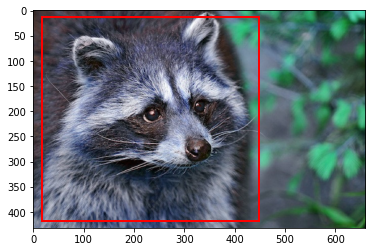

In [23]:
#Scale the predicted bounding box
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)
x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

#Import libraries for plotting Images
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

#Show the plot
plt.show()